# **Face Recognition Project: Brainstorming & Model Exploration**

## **1. Introduction**
In this notebook, I explore various machine learning models and techniques for a face recognition task. The goal is to classify facial images into one of 83 classes. This notebook documents my brainstorming process, including data exploration, model experimentation, and evaluation of results.

### **Project Overview**
- **Objective**: Develop a face recognition model to classify images into 83 classes.
- **Dataset**: PubFig83 dataset (13,840 images of 83 public figures).
- **Competition**: [Kaggle Face Recognition Competition](https://www.kaggle.com/competitions/ifsp-d3apl-2023-face-recognition/overview).

In [ ]:
# Standard Libraries
import time
from time import perf_counter  # For precise timing measurements

# Data Manipulation & Analysis
import pandas as pd  # DataFrame operations
import numpy as np   # Numerical computing

# Image Processing
import cv2  # OpenCV for image manipulation

# Machine Learning Framework
import tensorflow as tf  # Core Deep Learning framework
from tensorflow import keras  # High-level Keras API

# Model Architecture Components
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout,
    GlobalAveragePooling2D, BatchNormalization, Activation,
    ZeroPadding2D, AveragePooling2D
)

# Pre-trained Models
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50, VGG16  # Base architectures
)
from keras_vggface.vggface import VGGFace  # Specialized face recognition model
from deepface import DeepFace  # DeepFace framework integration

# Optimization & Training
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # Optimizers
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Training controls
)

# Data Preprocessing & Augmentation
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.preprocessing import LabelBinarizer, LabelEncoder  # Label encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Augmentation
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Model-specific preprocessing

# Visualization
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Enhanced visualizations

# Special Utilities
from tensorflow.keras.utils import to_categorical  # One-hot encoding

## **2. Data Exploration**
Before diving into model development, it's crucial to understand the dataset.

### **2.1 Dataset Description**
- **Training Data**: 12,180 labeled images.
- **Test Data**: 1,660 unlabeled images.
- **Image Size**: 100x100 pixels (resized and aligned).

### **2.2 Data Preprocessing**
- Resized images to 100x100 pixels.
- Split the training data into training and validation sets (80% training, 20% validation).
- Applied data augmentation techniques (rotation, flipping, zooming) to improve model generalization.

In [2]:
def generate_train_test(rows, cols):
    """
    Preprocesses the dataset, resizes images, and generates training and testing data generators.

    Args:
        rows (int): Target height for resizing images.
        cols (int): Target width for resizing images.

    Returns:
        train_generator: ImageDataGenerator for training data.
        test_generator: ImageDataGenerator for testing data.
    """
    # Load the dataset
    df = pd.read_csv('train.csv')
    
    # Resize images and handle missing files
    print("Resizing images and preprocessing...")
    for i, row in df.iterrows():
        img_path = row['image-pathname']
        img = cv2.imread(img_path)
        
        if img is not None:
            # Resize the image to the target dimensions
            img = cv2.resize(img, (rows, cols))
            # Save the resized image back to disk
            cv2.imwrite(img_path, img)
        else:
            print(f"Warning: Image not found at {img_path}. Skipping this entry.")
    
    # Split the dataset into training and testing sets
    print("Splitting dataset into training and testing sets...")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    
    # Configure data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,               # Normalize pixel values to [0, 1]
        shear_range=0.2,              # Randomly shear images
        zoom_range=0.2,               # Randomly zoom images
        horizontal_flip=True,        # Randomly flip images horizontally
        rotation_range=30,           # Randomly rotate images by up to 30 degrees
        width_shift_range=0.1,        # Randomly shift images horizontally
        height_shift_range=0.1        # Randomly shift images vertically
    )
    
    # Configure preprocessing for testing data (no augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create data generators for training and testing
    print("Creating data generators...")
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="image-pathname",      # Column containing image paths
        y_col="label",               # Column containing labels
        target_size=(rows, cols),    # Resize images to target dimensions
        class_mode='categorical'     # Use categorical labels for multi-class classification
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="image-pathname",
        y_col="label",
        target_size=(rows, cols),
        class_mode='categorical'
    )
    
    print("Data preprocessing complete.")
    return train_generator, test_generator

In [3]:
# Define target image dimensions
rows, cols = 100, 100

# Generate training and testing data generators
train_gen, test_gen = generate_train_test(rows, cols)

# Check the output
print(f"Training samples: {train_gen.samples}")
print(f"Testing samples: {test_gen.samples}")

Resizing images and preprocessing...
Splitting dataset into training and testing sets...
Creating data generators...
Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Data preprocessing complete.
Training samples: 9744
Testing samples: 2436


## **3. Model Exploration**

In this section, I explore and evaluate multiple machine learning models for the face recognition task. The goal is to identify the best-performing model based on accuracy, generalization, and computational efficiency. Below, I describe the models tested, the rationale behind their selection, and the evaluation metrics used.

### **3.1 Model Selection Rationale**
For this task, I focused on Convolutional Neural Networks (CNNs), as they are the state-of-the-art approach for image classification tasks. CNNs are capable of automatically learning spatial hierarchies of features from images, making them ideal for face recognition.

#### **Models Tested:**
1. **Baseline CNN**: A simple CNN architecture to establish a baseline performance.
2. **Transfer Learning with ResNet50**: Leveraging a pre-trained ResNet50 model to benefit from learned features on large datasets like ImageNet.
3. **Custom CNN with Data Augmentation**: A deeper CNN architecture combined with data augmentation to improve generalization.

#### **Evaluation Metrics:**
- **Accuracy**: Measures the proportion of correctly classified images. This is the primary metric for this task, as the dataset is balanced.
- **Loss (Categorical Cross-Entropy)**: Tracks the model's performance during training and validation. A lower loss indicates better model performance.
- **Confusion Matrix**: Provides insights into the model's performance across different classes, helping identify misclassifications.
- **Training Time**: Measures the computational efficiency of the model.



## 3.1 Baseline CNN Model

In [ ]:


def plot_history(history, title):
    """
    Plots the training and validation loss and accuracy from the model's history.

    Args:
        history: The history object returned by model.fit().
        title (str): The title of the plot.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:

def build_baseline_cnn(input_shape=(100, 100, 3), n_classes=83):
    model = Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, (4, 4), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    return model

In [ ]:


# Build the model
input_shape = (100, 100, 3)
n_classes = 83
model_baseline = build_baseline_cnn(input_shape, n_classes)

# Compile the model
model_baseline.compile(
    optimizer=SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history_baseline = model_baseline.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb]
)

Epoch 1/100
305/305 [==============================] - 52s 160ms/step - loss: 4.3602 - accuracy: 0.0261 - val_loss: 4.3226 - val_accuracy: 0.0275
Epoch 2/100
305/305 [==============================] - 14s 44ms/step - loss: 4.3126 - accuracy: 0.0384 - val_loss: 4.2788 - val_accuracy: 0.0505
Epoch 3/100
305/305 [==============================] - 13s 44ms/step - loss: 4.2634 - accuracy: 0.0464 - val_loss: 4.1922 - val_accuracy: 0.0644
Epoch 4/100
305/305 [==============================] - 14s 44ms/step - loss: 4.2010 - accuracy: 0.0560 - val_loss: 4.1074 - val_accuracy: 0.0776
Epoch 5/100
305/305 [==============================] - 13s 44ms/step - loss: 4.1252 - accuracy: 0.0648 - val_loss: 4.0218 - val_accuracy: 0.0842
Epoch 6/100
305/305 [==============================] - 13s 43ms/step - loss: 4.0599 - accuracy: 0.0708 - val_loss: 3.9376 - val_accuracy: 0.0887
Epoch 7/100
305/305 [==============================] - 13s 43ms/step - loss: 4.0092 - accuracy: 0.0760 - val_loss: 3.8833 - val_a

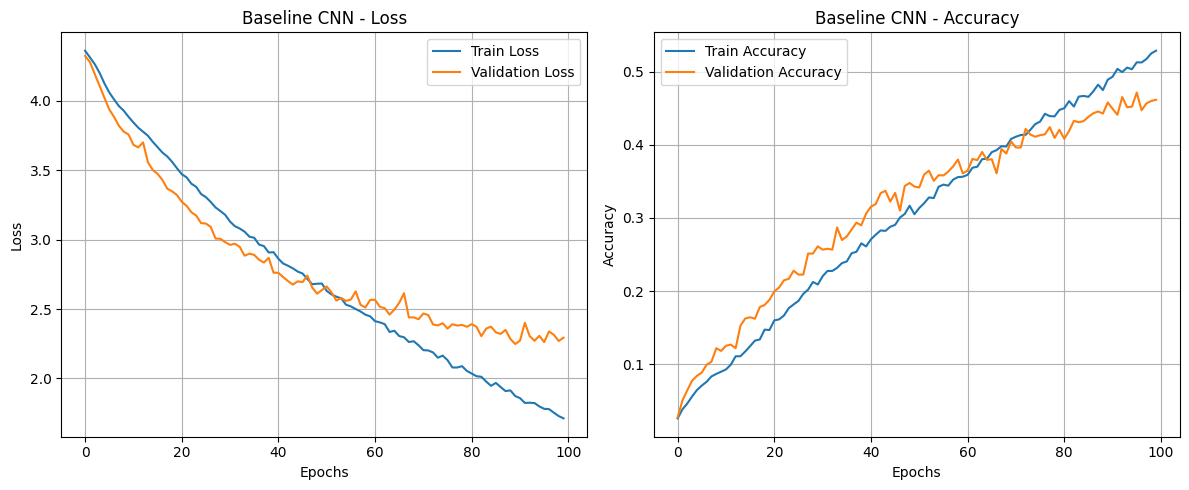

In [10]:
# Plotar os gráficos de treinamento e validação
plot_history(history_baseline, 'Baseline CNN')

# 4. Transfer Learning Benchmark
## 4.1 Model Testing Setup

In [ ]:

# Define models to test
models = {
    "MobileNet": {"model": tf.keras.applications.MobileNet, "perf": 0},
    "MobileNetV2": {"model": tf.keras.applications.MobileNetV2, "perf": 0},
    "DenseNet121": {"model": tf.keras.applications.DenseNet121, "perf": 0},
    "DenseNet169": {"model": tf.keras.applications.DenseNet169, "perf": 0},
    "DenseNet201": {"model": tf.keras.applications.DenseNet201, "perf": 0},
    "VGG16": {"model": tf.keras.applications.VGG16, "perf": 0},
    "VGG19": {"model": tf.keras.applications.VGG19, "perf": 0},
    "Xception": {"model": tf.keras.applications.Xception, "perf": 0}
}

# Configuration
input_shape = (100, 100, 3)
n_classes = 83
batch_size = 32
epochs = 50

## 4.2 Training Function

In [6]:
def train_transfer_learning_models(models_dict, input_shape, n_classes, train_gen, test_gen):
    results = {}
    
    for model_name, config in models_dict.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}\n")
        
        try:
            # Load pre-trained model
            base_model = config['model'](
                include_top=False,
                weights='imagenet',
                input_shape=input_shape
            )
            base_model.trainable = False  # Freeze base model
            
            # Build custom top layers
            inputs = tf.keras.Input(shape=input_shape)
            x = base_model(inputs, training=False)
            x = GlobalAveragePooling2D()(x)
            x = Dense(512, activation='relu')(x)
            x = Dropout(0.5)(x)
            outputs = Dense(n_classes, activation='softmax')(x)
            
            model = Model(inputs, outputs)
            
            # Compile
            model.compile(
                optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # Callbacks
            callbacks = [
                EarlyStopping(patience=10, restore_best_weights=True),
                ReduceLROnPlateau(factor=0.2, patience=5)
            ]
            
            # Train
            history = model.fit(
                train_gen,
                validation_data=test_gen,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=2
            )
            
            # Store results
            config['perf'] = max(history.history['val_accuracy'])
            results[model_name] = history
            
        except Exception as e:
            print(f"Error in {model_name}: {str(e)}")
            continue
            
    return results

## 4.5 Execute Training

In [7]:
# Train all models
results = train_transfer_learning_models(models, input_shape, n_classes, train_gen, test_gen)


Training MobileNet

Epoch 1/50
305/305 - 58s - loss: 4.1029 - accuracy: 0.0760 - val_loss: 3.4432 - val_accuracy: 0.1700 - lr: 0.0010 - 58s/epoch - 190ms/step
Epoch 2/50
305/305 - 13s - loss: 3.5574 - accuracy: 0.1346 - val_loss: 3.1546 - val_accuracy: 0.2225 - lr: 0.0010 - 13s/epoch - 44ms/step
Epoch 3/50
305/305 - 13s - loss: 3.3624 - accuracy: 0.1715 - val_loss: 2.9858 - val_accuracy: 0.2418 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 4/50
305/305 - 13s - loss: 3.2383 - accuracy: 0.1848 - val_loss: 2.9407 - val_accuracy: 0.2652 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 5/50
305/305 - 13s - loss: 3.1617 - accuracy: 0.1991 - val_loss: 2.8205 - val_accuracy: 0.2898 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 6/50
305/305 - 13s - loss: 3.0977 - accuracy: 0.2162 - val_loss: 2.7610 - val_accuracy: 0.2980 - lr: 0.0010 - 13s/epoch - 43ms/step
Epoch 7/50
305/305 - 13s - loss: 3.0565 - accuracy: 0.2186 - val_loss: 2.7506 - val_accuracy: 0.3079 - lr: 0.0010 - 13s/epoch - 44ms/step
Epoch 8/50
3

## 4.4 Results Visualization

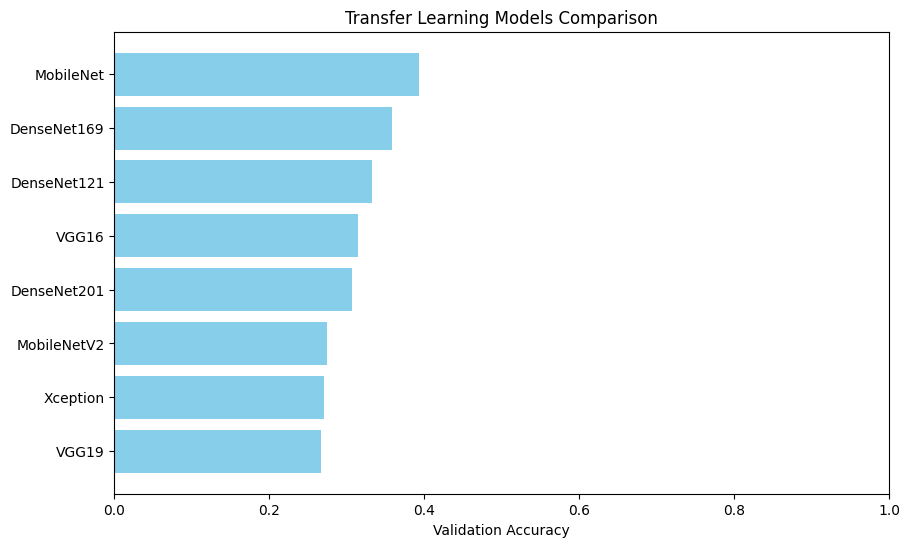

In [ ]:
# Create performance dataframe
results_df = pd.DataFrame({
    'Model': models.keys(),
    'Validation Accuracy': [m['perf'] for m in models.values()]
}).sort_values('Validation Accuracy', ascending=False)

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.title('Transfer Learning Models Comparison')
plt.xlim(0, 1.0)
plt.gca().invert_yaxis()
plt.show()

# 5. Testing Specific Models for Face Recognition
## **5.1 VGGFace**
- **Model Setup**: Load VGGFace, freeze layers, and add custom top layers.
- **Training**: Use `Adam` optimizer, `EarlyStopping`, and `ModelCheckpoint`.
- **Visualization**: Plot training and validation loss/accuracy.
### 5.1.1 Model Setup

In [ ]:

# Create the base pre-trained model
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(83, activation='softmax')(x)

# Create the final model
model_vggface = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vggface.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 5.1.2 Callbacks and Training

In [13]:
# Callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "VGG_Face.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# Generate training and testing data
train_generator, test_generator = generate_train_test(224, 224)

# Train the model
history_vggface = model_vggface.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping_cb, checkpoint],
    verbose=1
)

Resizing images and preprocessing...
Splitting dataset into training and testing sets...
Creating data generators...
Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Data preprocessing complete.
Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 3.2710 - accuracy: 0.2658
Epoch 1: val_loss improved from inf to 2.13592, saving model to VGG_Face.h5
305/305 [==============================] - 99s 319ms/step - loss: 3.2710 - accuracy: 0.2658 - val_loss: 2.1359 - val_accuracy: 0.8748
Epoch 2/20
305/305 [==============================] - ETA: 0s - loss: 1.4975 - accuracy: 0.6226
Epoch 2: val_loss improved from 2.13592 to 0.32422, saving model to VGG_Face.h5
305/305 [==============================] - 53s 174ms/step - loss: 1.4975 - accuracy: 0.6226 - val_loss: 0.3242 - val_accuracy: 0.9499
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.7420
Epoch 3: val_loss 

### 5.1.3 Visualization of Results

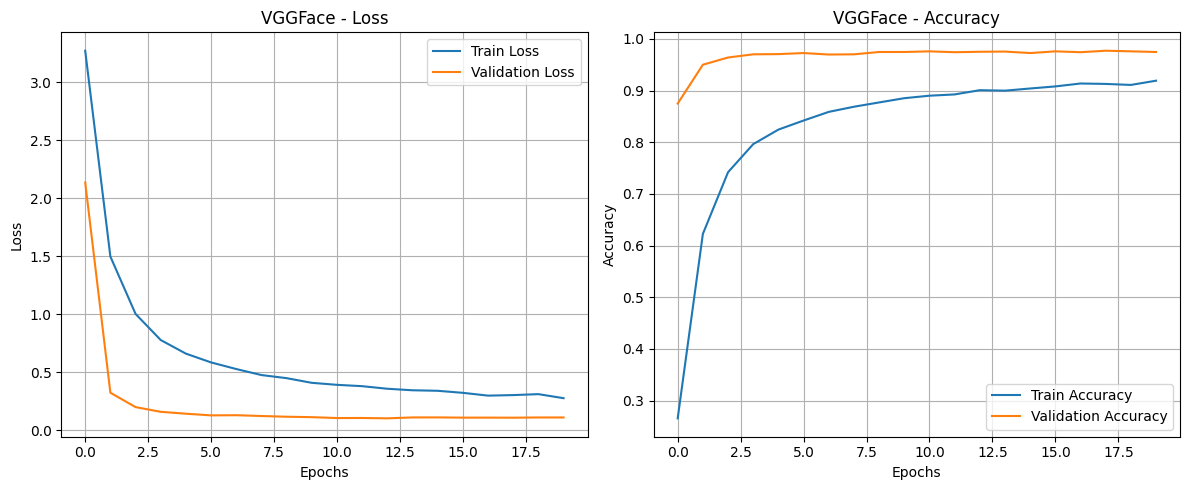

In [14]:
# Plot training history
plot_history(history_vggface, 'VGGFace')

## **5.2 DeepFace**
- **Model Setup**: Load DeepFace, freeze layers, and add custom top layers.
- **Training**: Use `Adam` optimizer, `EarlyStopping`, and `ModelCheckpoint`.
- **Visualization**: Plot training and validation loss/accuracy.
### 5.2.1 Model Setup

In [ ]:


# Create the base DeepFace model
base_model = DeepFace.build_model('VGG-Face')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(83, activation='softmax')(x)

# Create the final model
model_deepface = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_deepface.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 5.2.2 Callbacks and Training


In [16]:
# Callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "DeepFace.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# Generate training and testing data
train_generator, test_generator = generate_train_test(224, 224)

# Train the model
history_deepface = model_deepface.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping_cb, checkpoint],
    verbose=1
)

Resizing images and preprocessing...
Splitting dataset into training and testing sets...
Creating data generators...
Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Data preprocessing complete.
Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 4.0518 - accuracy: 0.1622
Epoch 1: val_loss improved from inf to 3.58011, saving model to DeepFace.h5
305/305 [==============================] - 100s 321ms/step - loss: 4.0518 - accuracy: 0.1622 - val_loss: 3.5801 - val_accuracy: 0.3181
Epoch 2/20
305/305 [==============================] - ETA: 0s - loss: 3.2086 - accuracy: 0.3407
Epoch 2: val_loss improved from 3.58011 to 2.80771, saving model to DeepFace.h5
305/305 [==============================] - 56s 183ms/step - loss: 3.2086 - accuracy: 0.3407 - val_loss: 2.8077 - val_accuracy: 0.5283
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 2.5579 - accuracy: 0.5116
Epoch 3: val_loss

### 5.2.3 Visualization of Results


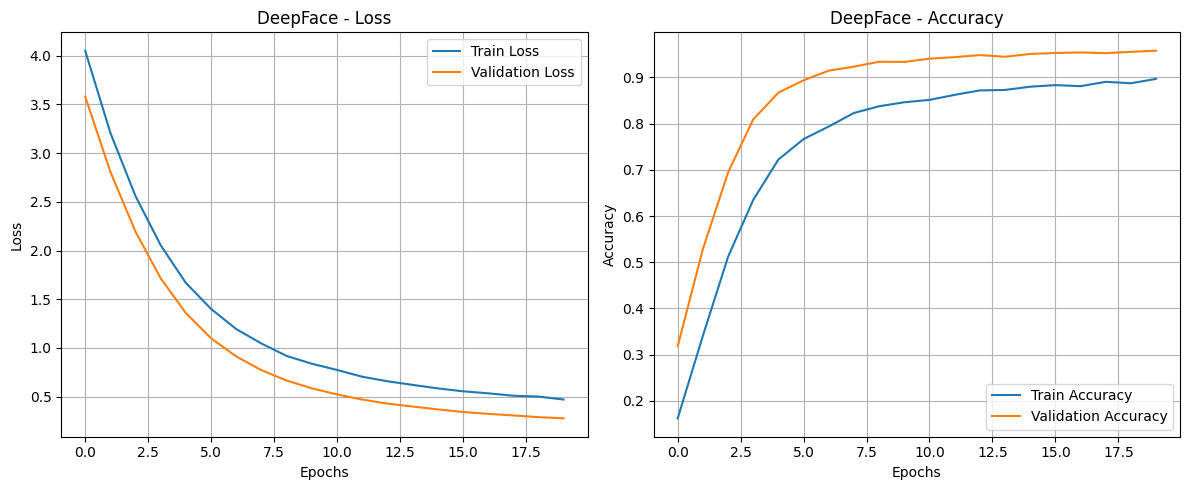

In [17]:
# Plot training history
plot_history(history_deepface, 'DeepFace')

## 5.3 Model Comparison

In [44]:
print(f"VGGFace Validation Accuracy: {max(history_vggface.history['val_accuracy'])}")
print(f"DeepFace Validation Accuracy: {max(history_deepface.history['val_accuracy'])}")

VGGFace Validation Accuracy: 0.977011501789093
DeepFace Validation Accuracy: 0.9577175974845886
